# Module 7 Assignment 1: Digit Recognizer

**Sachin Sharma**

**MSDS-422**

**08/03/2024**

## Management/Research Question
In layman’s terms, what is the management/research question of interest, and why would anyone care?  

Requirements
1. Conduct your analysis using a cross-validation design.
2. Conduct / refine EDA.
3. Conduct Design of Experiments to evaluate the performance of various neural networks by changing the layers and nodes. Tested neural network structures should be explored within a benchmark experiment, a 2x2 completely crossed design. An example of a completely crossed designed with {2, 5} layers and {10,20} nodes follows.

Layers| Nodes| Time| Training Accuracy| Testing Accuracy
---|---|---|---|---
2| 10| 63.61| 0.935| 0.927
2| 20| 115.25| 0.967| 0.952
5| 10| 74.28| 0.944| 0.933
5| 20| 75.1| 0.964| 0.952

4. Due to the time required to fit each neural network, we will observe only one trial for each cell in the design.
5. You will build your models on csv and submit your forecasts for test.csv to Kaggle.com, providing your name and user ID for each experimental trial.
6. Evaluate goodness of fit metrics on the training and validation sets.
7. Provide a multi-class confusion matrix.
8. Discuss how your models performed.


### Libraries to be loaded

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.layers as preprocessing
import warnings
import os
# Ignore all FutureWarnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/MyDrive

/content/drive/MyDrive


In [4]:
def set_seed(seed=422):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

## Ingest

In [5]:
df_train = pd.read_csv("MNIST/train.csv")
df_train.name = 'Training Set'
df_train.shape

(42000, 785)

In [6]:
df_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [7]:
df_test = pd.read_csv("MNIST/test.csv")
df_test.name = 'Test Set'
df_test.shape

(28000, 784)

## EDA

In [8]:
print("Null values in Train DF: ",df_train.isna().sum().sum())
print("Null values in Test DF: ",df_test.isna().sum().sum())

Null values in Train DF:  0
Null values in Test DF:  0


In [9]:
dfs = [df_train, df_test]

for df in dfs:
  obs = df.shape[0]
  tot = df.shape[1]
  numeric = df.select_dtypes(include=np.number).shape[1]
  categorical = df.select_dtypes(exclude=np.number).shape[1]
  print('In {} we have {} observations, {} variables: {} numeric and {} categorical'.format(df.name, obs, tot, numeric, categorical))

In Training Set we have 42000 observations, 785 variables: 785 numeric and 0 categorical
In Test Set we have 28000 observations, 784 variables: 784 numeric and 0 categorical


Let's output some sample digits as a 28x28 pixel image.

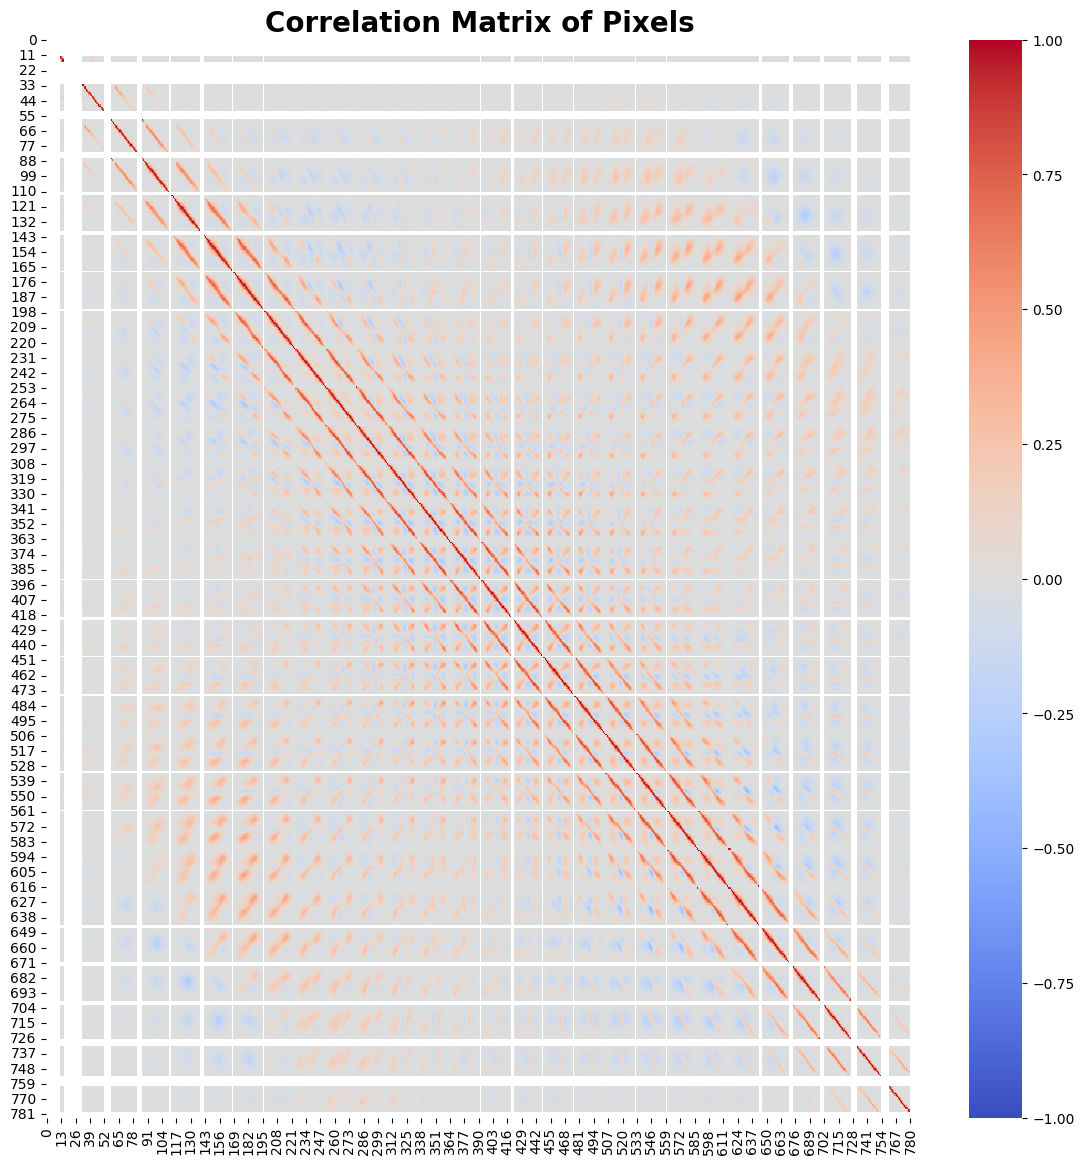

In [10]:
# Compute the correlation matrix
images = df_train.drop(columns=['label']).values
labels = df_train['label'].values

flat_images = images.reshape(-1, 28*28)
correlation_matrix = np.corrcoef(flat_images.T)

# Plot the correlation matrix
plt.figure(figsize=(14, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Pixels", size=20, fontweight='bold')
plt.show();

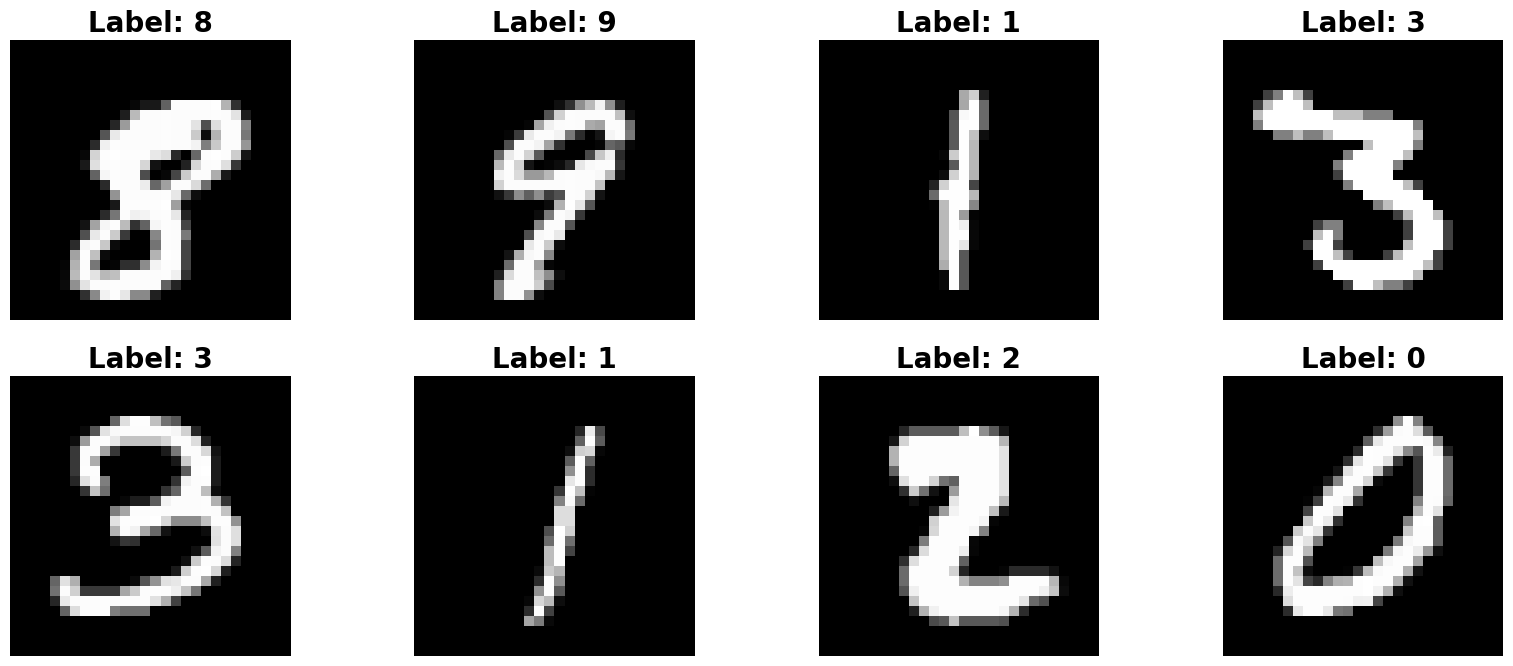

In [11]:
labels = df_train['label'].values
images = df_train.drop(columns=['label']).values

# Reshape the images
images = images.reshape(-1, 28, 28)

# Combine images and labels into a single dataset
dataset = list(zip(images, labels))

# Plot images from the dataset with their corresponding labels
plt.figure(figsize=(20, 8))
for i in range(10, 18):
    image, label = dataset[i]
    plt.subplot(2, 4, i-9)  # Adjust subplot indexing to match the desired layout (2 rows, 4 columns)
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + str(label), fontweight='bold', size=20)
    plt.axis('off')  # Turn off axis

plt.show()

Let's look at the distribution of digits in the training set.

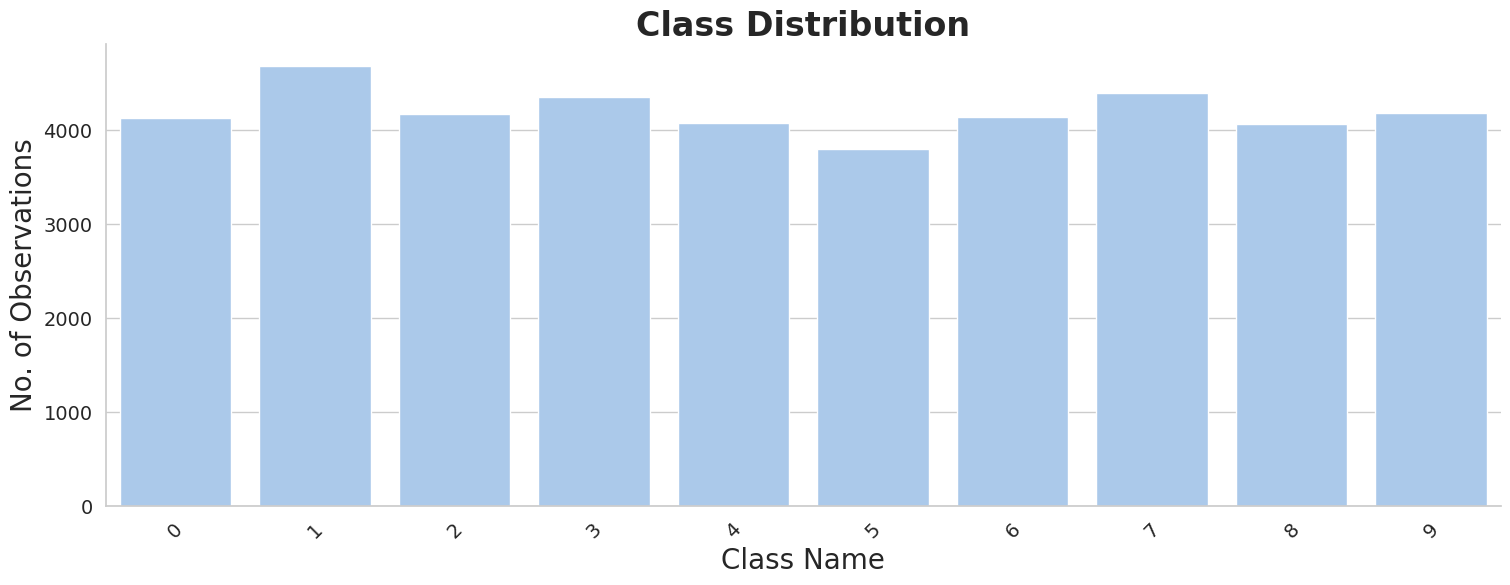

In [12]:
# Set the style and color palette
sns.set(style="whitegrid", palette="pastel")

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(18, 6))

# Plot the countplot
sns.countplot(x='label', data=df_train, ax=ax)

# Customize the plot
ax.set_title("Class Distribution", size=24, fontweight='bold')
ax.set_ylabel("No. of Observations", size=20)
ax.set_xlabel("Class Name", size=20)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Remove the top and right spines
sns.despine()

# Show the plot
plt.show()

In [13]:
df_train['label'].value_counts().sort_values()

,count
label,
5,3795
8,4063
4,4072
0,4132
6,4137
2,4177
9,4188
3,4351
7,4401


In [14]:
df_train_original = df_train.copy()
df_test_original = df_test.copy()

# ntrain allows us to keep track of the length of the training set for later segmentation of train/test
ntrain = df_train.shape[0]

y_var = 'label'
y_train_original = df_train[y_var]
y_train = y_train_original.copy()

df_train.drop([y_var], axis=1, inplace=True)
df_train = df_train.astype(float) / 255 # This converts all of the shadings from 0-255 --> 0-1
df_test = df_test.astype(float) / 255 # Same as above

df_train = df_train.to_numpy().reshape(df_train.shape[0],28,28,1)  # This reorients the data into the shape Keras expects
df_test = df_test.to_numpy().reshape(df_test.shape[0],28,28,1) # Same as above

#### Augmentation Function

In [15]:
def data_augmentation(X, y):

    # Defining the data augmentations using Keras preprocessing layers
    data_augmentation1 = keras.Sequential([
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant'),
        preprocessing.RandomRotation(factor=0.1, fill_mode='constant')
    ])

    data_augmentation2 = keras.Sequential([
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant'),
        preprocessing.RandomZoom(height_factor=0.15, width_factor=0.15, fill_mode='constant')
    ])

    data_augmentation3 = keras.Sequential([
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant'),
        preprocessing.RandomZoom(height_factor=0.15, width_factor=0.15, fill_mode='constant'),
        preprocessing.RandomRotation(factor=0.1, fill_mode='constant')
    ])

    # Generating the augmented samples
    X_new1_1 = data_augmentation1(X)
    X_new1_2 = data_augmentation1(X)
    X_new1_3 = data_augmentation1(X)
    X_new2_1 = data_augmentation2(X)
    X_new2_2 = data_augmentation2(X)
    X_new2_3 = data_augmentation2(X)
    X_new3_1 = data_augmentation3(X)
    X_new3_2 = data_augmentation3(X)
    X_new3_3 = data_augmentation3(X)

    # Concatenating X with the augmented samples
    X = np.concatenate((X, X_new1_1, X_new1_2, X_new1_3, X_new2_1, X_new2_2, X_new2_3, X_new3_1, X_new3_2, X_new3_3))
    y = pd.concat([y, y.copy(), y.copy(), y.copy(), y.copy(), y.copy(), y.copy(), y.copy(), y.copy(), y.copy()], ignore_index=True)

    return X, y

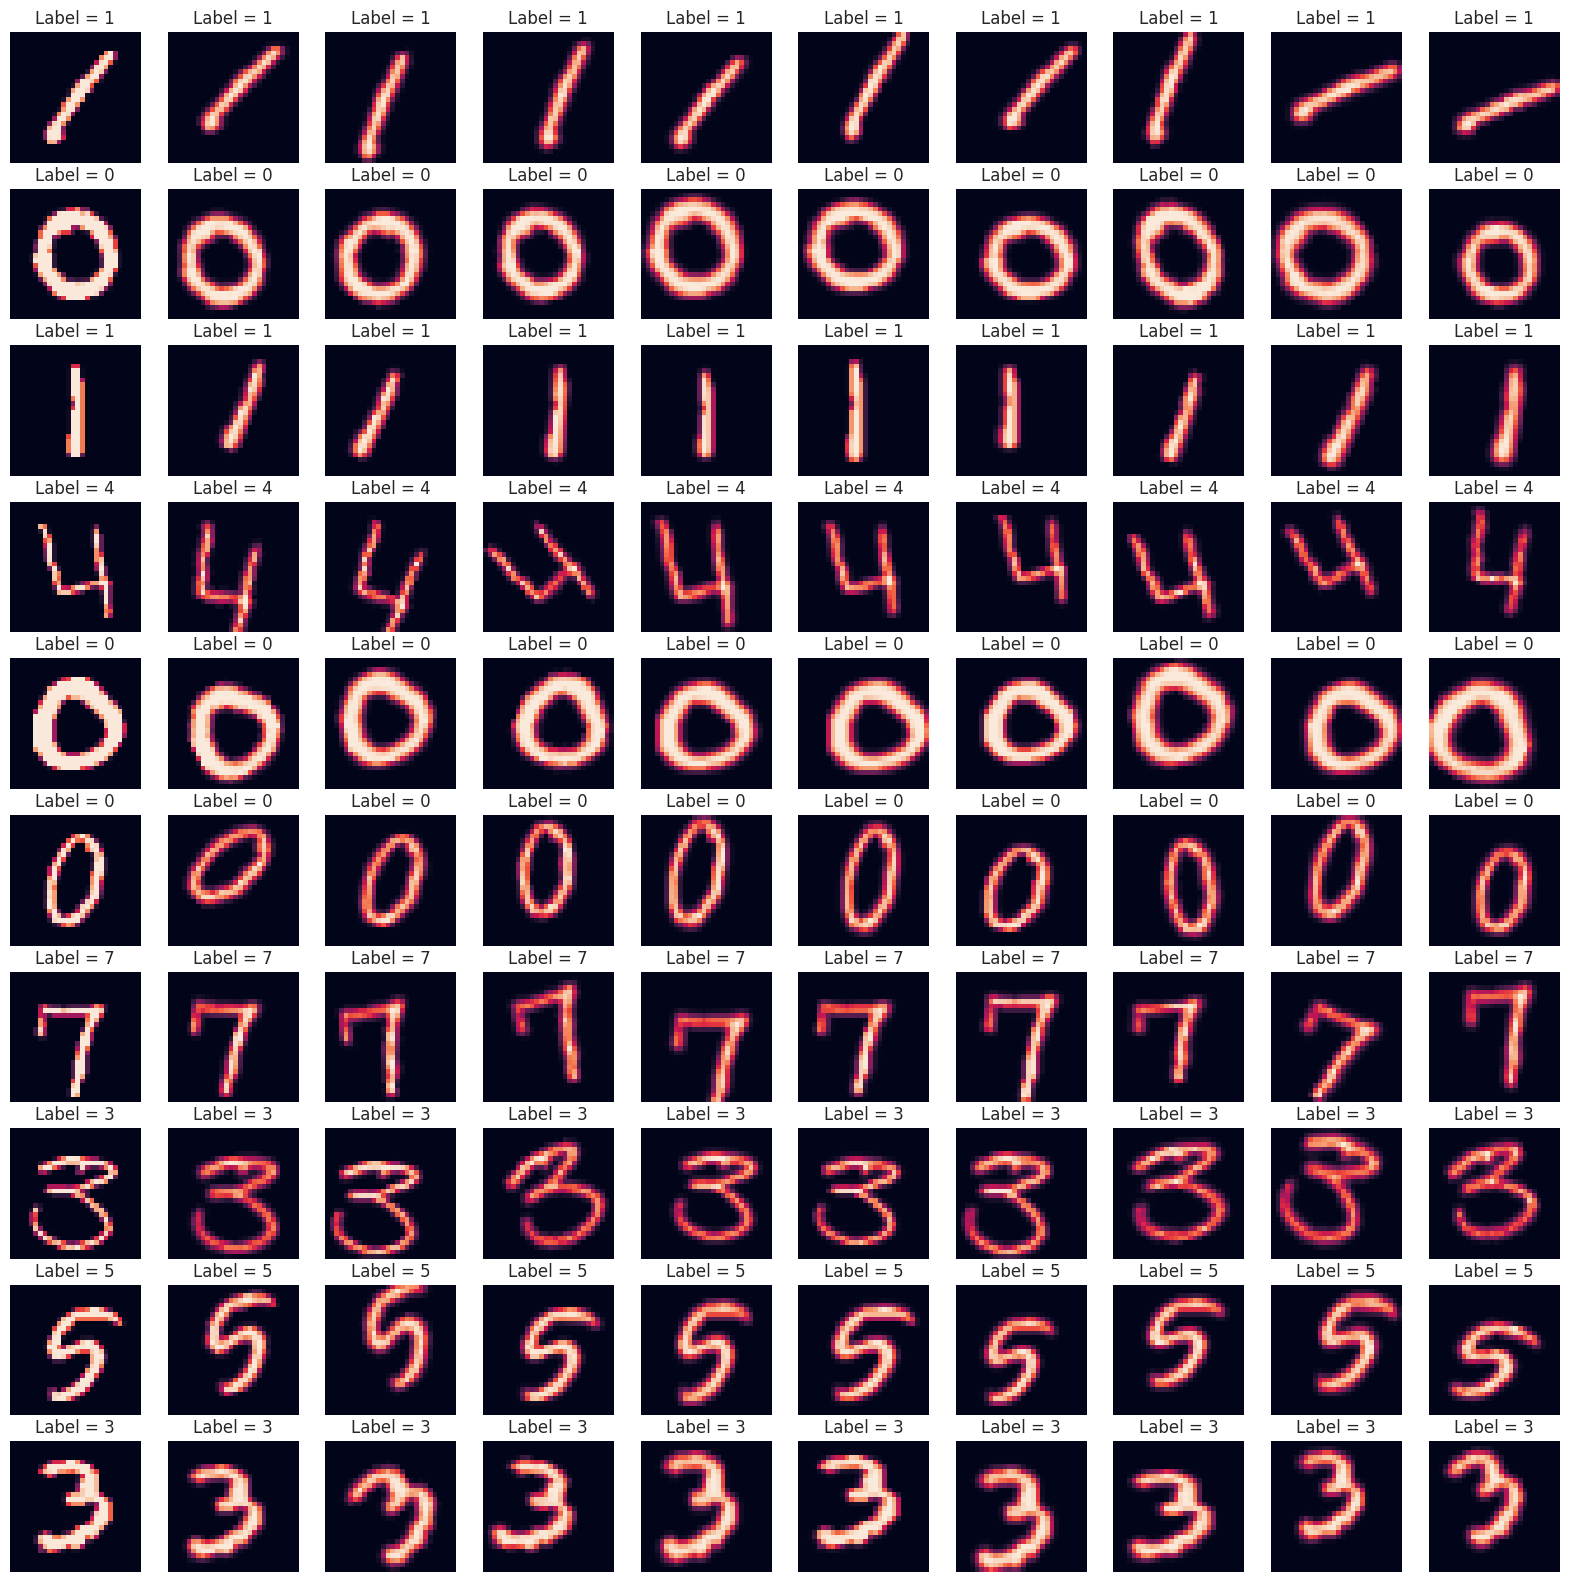

In [16]:
X10 = df_train[0:10]
y10 = y_train[0:10]
X100, y100 = data_augmentation(X10, y10)

fig=plt.figure(figsize=(20,20))
pos = 1
for i in range(0, 10):
    for j in range(i+0, i+100, 10):
        fig.add_subplot(10, 10, pos)
        plt.imshow(tf.squeeze(X100[j]))
        plt.title('Label = ' + str(y100[j]))
        plt.axis('off')
        pos = pos + 1
plt.show()

### Build Neural Networks (6 Models)
1. 2 Layers 100 Nodes
2. 2 Layers 200 Nodes
3. 3 Layers 100 Nodes
4. 3 Layers 200 Nodes
5. 5 Layers 100 Nodes
6. 5 Layers 200 Nodes

In [17]:
def build_model(hidden_layers, hidden_nodes, dropout):

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

  for i in range(1,hidden_layers+1):
    model.add(tf.keras.layers.Dense(hidden_nodes, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Dense(10, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

  return model

model = build_model(hidden_layers = 2, hidden_nodes = 300, dropout = 0.2)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 300)                 │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           3,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 328,810 (1.25 MB)

 Trainable params: 328,810 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
N_EPOCHS = 10
# Cross Validation with N_SPLITS.
N_SPLITS = 5
N_ITERATION = 1

#### Model 1 (2 layers, 100 node) Training with Cross-Validation

In [19]:
start_time = datetime.now()
# Creating hist_df to store history objects for each training / split
hist_df = pd.DataFrame(columns=['iteration', 'history'])
iteration = 1
index = 0

hidden_layers = 2
hidden_nodes = 100
dropout = 0.2

saved_model = False
X_train = df_train.reshape(42000, 784)

skf = StratifiedKFold(n_splits = N_SPLITS, shuffle = True, random_state = 422)
for train_index, val_index in skf.split(X_train, y_train):

    # Getting the training set and validation set before data augmentation
    X_train_, X_val_ = X_train[train_index], X_train[val_index]
    X_train_ = X_train_.reshape(33600,28,28,1) # Reshaping X_train to Keras input format
    X_val_ = X_val_.reshape(8400,28,28,1) # Reshaping X_val to Keras input format
    y_train_, y_val_ = y_train[train_index], y_train[val_index]

    # Generating augmented samples
    X_train_, y_train_ = data_augmentation(X_train_, y_train_)

    # Building the model
    model = build_model(hidden_layers, hidden_nodes, dropout)

    # EDIT THE NEXT ROW FOR EACH MODEL
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("MNIST/checkpoint/Model-2L100N.keras", save_best_only=True)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

    # Training and evaluating each model for this split
    history = model.fit(x = X_train_, y = y_train_, validation_data=(X_val_, y_val_),
                        epochs=N_EPOCHS, batch_size=64, callbacks=[checkpoint_cb, early_stopping_cb])

    # Saving the trained model as a saved model file -- only one model is saved
    if(saved_model == False):
        model.save('MNIST/trained_models/Model-2L100N.keras')
        saved_model = True

    # Storing the history objects into a dataframe
    hist_df.loc[index, 'iteration'] = iteration
    hist_df.loc[index, 'history'] = history

    if(iteration == N_ITERATION):
        break

    index = index + 1
    iteration = iteration + 1

end_time = datetime.now()
print('\nTime taken to Train Model with 2 Layers and 100 nodes: {}'.format(end_time - start_time))

Epoch 1/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.4601 - loss: 1.5978 - val_accuracy: 0.9223 - val_loss: 0.3316
Epoch 2/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.7573 - loss: 0.7710 - val_accuracy: 0.9454 - val_loss: 0.2102
Epoch 3/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8136 - loss: 0.5940 - val_accuracy: 0.9561 - val_loss: 0.1687
Epoch 4/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8399 - loss: 0.5136 - val_accuracy: 0.9599 - val_loss: 0.1465
Epoch 5/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8557 - loss: 0.4626 - val_accuracy: 0.9640 - val_loss: 0.1315
Epoch 6/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8646 - loss: 0.4320 - val_accuracy: 0.9651 - val_loss: 0.1223
Epoch 7/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8737 - loss: 0.4040 - val_accuracy: 0.9675 - val_loss: 0.1135
Epoch 8/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8793 - loss: 0

#### Model Performance Evaluation

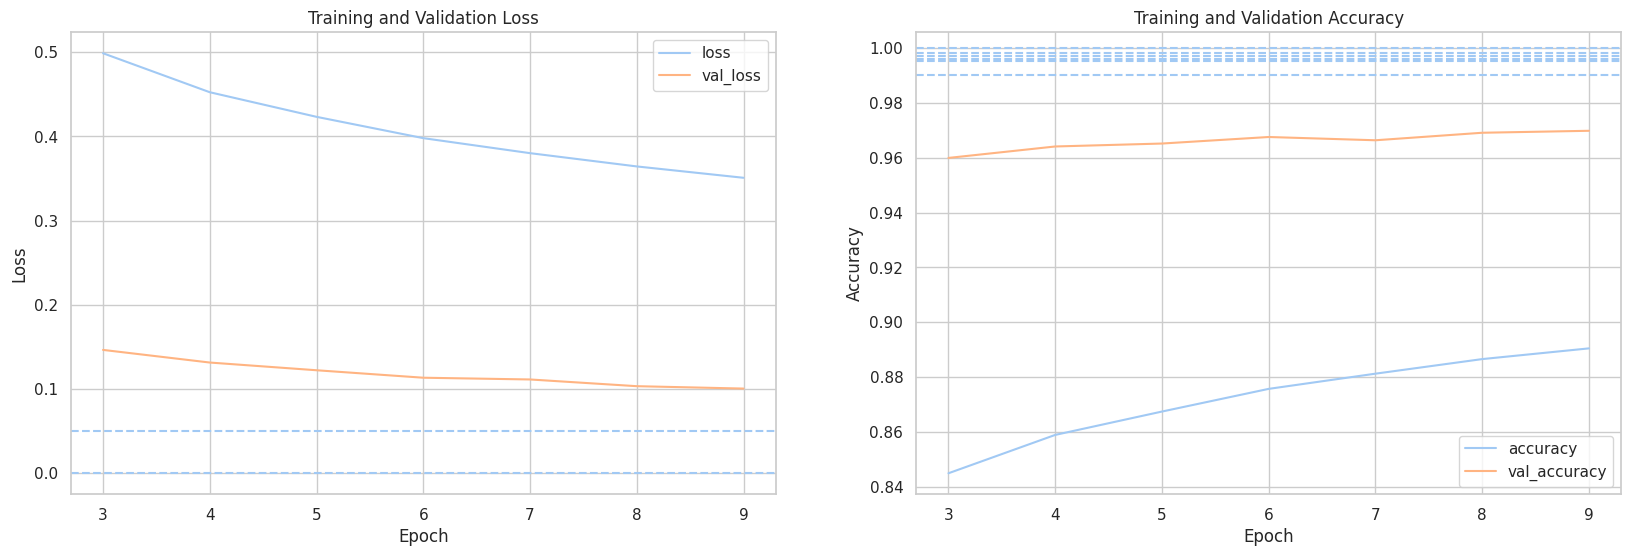

In [20]:
hist = []
for i in range(N_ITERATION):
    hist.append(pd.DataFrame(hist_df[hist_df['iteration']==(i+1)]['history'][i].history))
    if i==0:
        hist_full = hist[0]
    else:
        hist_full = pd.concat([hist_full, hist[i]])

# Dropping the 1st EPOCHS of each iteration because their losses are high and their accuracies are low
hist_full.drop([0,1,2], inplace=True)  # 3 EPOCHS dropped / iteration

# Displaying CV metrics
fig,axes=plt.subplots(1,2,figsize=(20,6))
sns.lineplot(data=hist_full[['loss','val_loss']], dashes=False, ax=axes[0])
axes[0].axhline(0.05, ls='--')
axes[0].axhline(0, ls='--')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
sns.lineplot(data=hist_full[['accuracy', 'val_accuracy']], dashes=False, ax=axes[1])
axes[1].axhline(0.99, ls='--')
axes[1].axhline(0.995, ls='--')
axes[1].axhline(0.996, ls='--')
axes[1].axhline(0.997, ls='--')
axes[1].axhline(0.998, ls='--')
axes[1].axhline(1, ls='--')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
plt.show()

#### Model Confusion Matrix

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


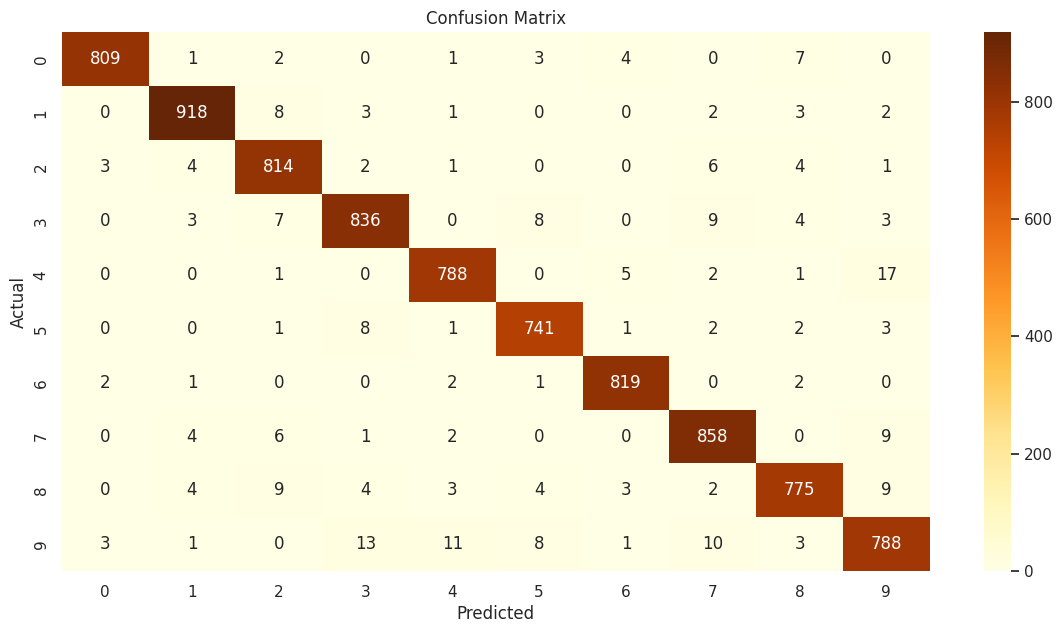

In [21]:
# Load the saved model
try:
    model = keras.models.load_model('MNIST/trained_models/Model-2L100N.keras')
except Exception as e:
    print(f"Error loading model: {e}")

# Reshape X_train
X_train = df_train.reshape(-1, 784)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=422)

# Retrieve the validation set from the first fold
for _, val_index in skf.split(X_train, y_train):
    X_val = X_train[val_index]
    y_val = y_train[val_index]
    break

# Reshape validation set for Keras
X_val = X_val.reshape(-1, 28, 28, 1)

# Make predictions
scores = model.predict(X_val)
y_pred = np.argmax(scores, axis=1)

# Display the confusion matrix
plt.figure(figsize=(14, 7))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Submission

In [22]:
X_test = df_test.copy()
X_test = X_test.reshape(28000,28,28,1)

model = keras.models.load_model('MNIST/trained_models/Model-2L100N.keras')
predictions = model.predict(X_test)

output = pd.DataFrame({'ImageId': list(range(1, 28001)), 'Label': np.argmax(predictions, axis=1)})
output.to_csv('MNIST/submission/Model-2L100N.csv', index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


#### Model 2 (2 layers, 200 node) Training with Cross-Validation

In [23]:
start_time = datetime.now()
# Creating hist_df to store history objects for each training / split
hist_df = pd.DataFrame(columns=['iteration', 'history'])
iteration = 1
index = 0

hidden_layers = 2
hidden_nodes = 200
dropout = 0.2

saved_model = False
X_train = df_train.reshape(42000, 784)

skf = StratifiedKFold(n_splits = N_SPLITS, shuffle = True, random_state = 422)
for train_index, val_index in skf.split(X_train, y_train):

    # Getting the training set and validation set before data augmentation
    X_train_, X_val_ = X_train[train_index], X_train[val_index]
    X_train_ = X_train_.reshape(33600,28,28,1) # Reshaping X_train to Keras input format
    X_val_ = X_val_.reshape(8400,28,28,1) # Reshaping X_val to Keras input format
    y_train_, y_val_ = y_train[train_index], y_train[val_index]

    # Generating augmented samples
    X_train_, y_train_ = data_augmentation(X_train_, y_train_)

    # Building the model
    model = build_model(hidden_layers, hidden_nodes, dropout)

    # EDIT THE NEXT ROW FOR EACH MODEL
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("MNIST/checkpoint/Model-2L200N.keras", save_best_only=True)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

    # Training and evaluating each model for this split
    history = model.fit(x = X_train_, y = y_train_, validation_data=(X_val_, y_val_),
                        epochs=N_EPOCHS, batch_size=64, callbacks=[checkpoint_cb, early_stopping_cb])

    # Saving the trained model as a saved model file -- only one model is saved
    if(saved_model == False):
        model.save('MNIST/trained_models/Model-2L200N.keras')
        saved_model = True

    # Storing the history objects into a dataframe
    hist_df.loc[index, 'iteration'] = iteration
    hist_df.loc[index, 'history'] = history

    if(iteration == N_ITERATION):
        break

    index = index + 1
    iteration = iteration + 1

end_time = datetime.now()
print('\nTime taken to Train Model with 2 Layers and 200 nodes: {}'.format(end_time - start_time))

Epoch 1/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.5056 - loss: 1.4934 - val_accuracy: 0.9279 - val_loss: 0.2975
Epoch 2/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7958 - loss: 0.6611 - val_accuracy: 0.9489 - val_loss: 0.1836
Epoch 3/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8506 - loss: 0.4837 - val_accuracy: 0.9601 - val_loss: 0.1448
Epoch 4/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8749 - loss: 0.4072 - val_accuracy: 0.9656 - val_loss: 0.1234
Epoch 5/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8902 - loss: 0.3613 - val_accuracy: 0.9670 - val_loss: 0.1106
Epoch 6/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8999 - loss: 0.3279 - val_accuracy: 0.9701 - val_loss: 0.0996
Epoch 7/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9071 - loss: 0.3029 - val_accuracy: 0.9712 - val_loss: 0.0921
Epoch 8/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9129 - loss: 0

#### Model Performance Evaluation

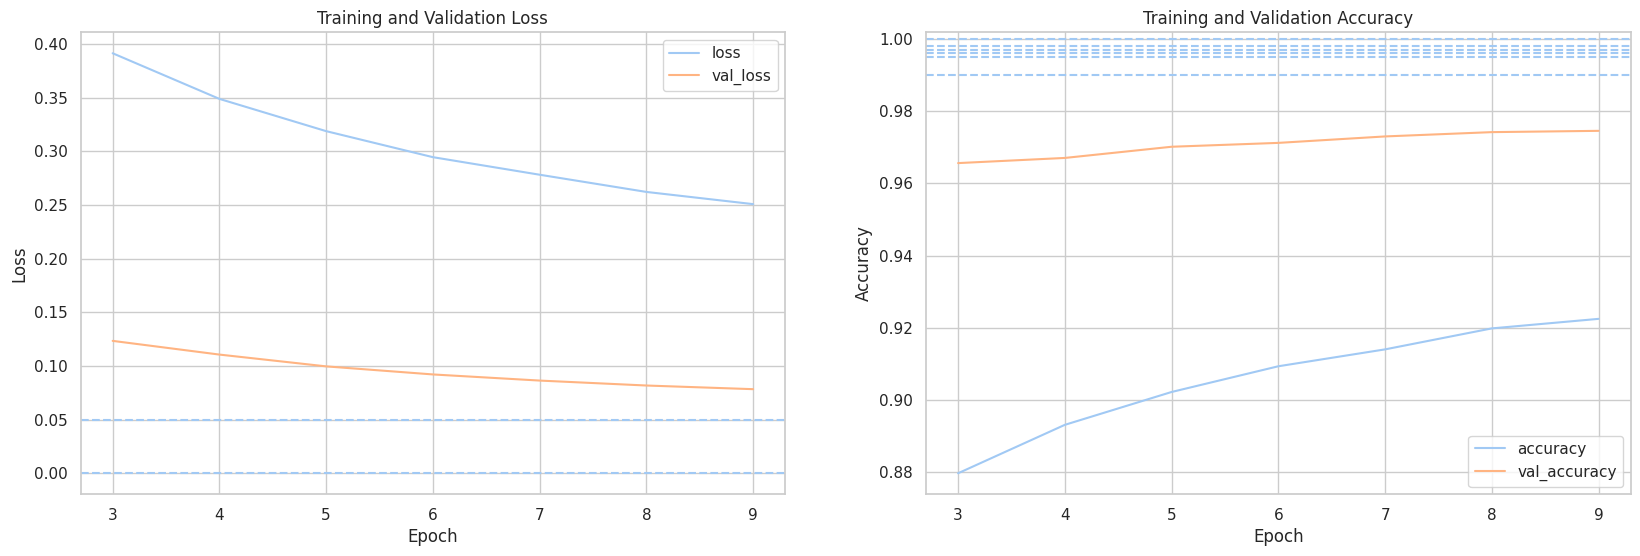

In [24]:
hist = []
for i in range(N_ITERATION):
    hist.append(pd.DataFrame(hist_df[hist_df['iteration']==(i+1)]['history'][i].history))
    if i==0:
        hist_full = hist[0]
    else:
        hist_full = pd.concat([hist_full, hist[i]])

# Dropping the 1st EPOCHS of each iteration because their losses are high and their accuracies are low
hist_full.drop([0,1,2], inplace=True)  # 3 EPOCHS dropped / iteration

# Displaying CV metrics
fig,axes=plt.subplots(1,2,figsize=(20,6))
sns.lineplot(data=hist_full[['loss','val_loss']], dashes=False, ax=axes[0])
axes[0].axhline(0.05, ls='--')
axes[0].axhline(0, ls='--')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
sns.lineplot(data=hist_full[['accuracy', 'val_accuracy']], dashes=False, ax=axes[1])
axes[1].axhline(0.99, ls='--')
axes[1].axhline(0.995, ls='--')
axes[1].axhline(0.996, ls='--')
axes[1].axhline(0.997, ls='--')
axes[1].axhline(0.998, ls='--')
axes[1].axhline(1, ls='--')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
plt.show()

#### Model Confusion Matrix

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


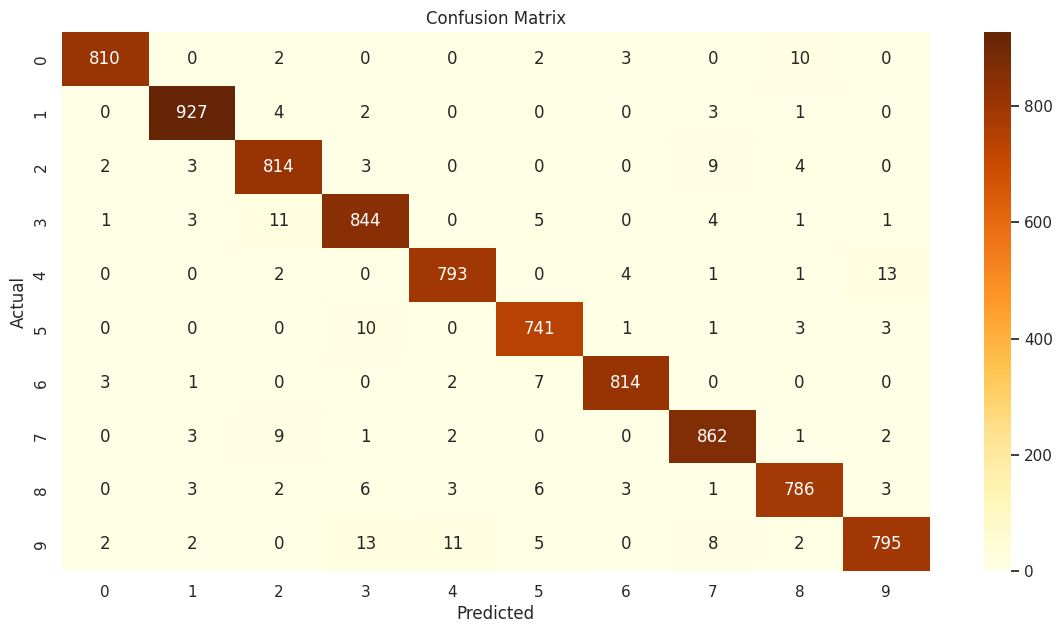

In [25]:
# Load the saved model
try:
    model = keras.models.load_model('MNIST/trained_models/Model-2L200N.keras')
except Exception as e:
    print(f"Error loading model: {e}")

# Reshape X_train
X_train = df_train.reshape(-1, 784)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=422)

# Retrieve the validation set from the first fold
for _, val_index in skf.split(X_train, y_train):
    X_val = X_train[val_index]
    y_val = y_train[val_index]
    break

# Reshape validation set for Keras
X_val = X_val.reshape(-1, 28, 28, 1)

# Make predictions
scores = model.predict(X_val)
y_pred = np.argmax(scores, axis=1)

# Display the confusion matrix
plt.figure(figsize=(14, 7))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Submission

In [26]:
X_test = df_test.copy()
X_test = X_test.reshape(28000,28,28,1)

model = keras.models.load_model('MNIST/trained_models/Model-2L200N.keras')
predictions = model.predict(X_test)

output = pd.DataFrame({'ImageId': list(range(1, 28001)), 'Label': np.argmax(predictions, axis=1)})
output.to_csv('MNIST/submission/Model-2L200N.csv', index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


#### Model 3 (3 layers, 100 node) Training with Cross-Validation

In [27]:
start_time = datetime.now()
# Creating hist_df to store history objects for each training / split
hist_df = pd.DataFrame(columns=['iteration', 'history'])
iteration = 1
index = 0

hidden_layers = 3
hidden_nodes = 100
dropout = 0.2

saved_model = False
X_train = df_train.reshape(42000, 784)

skf = StratifiedKFold(n_splits = N_SPLITS, shuffle = True, random_state = 422)
for train_index, val_index in skf.split(X_train, y_train):

    # Getting the training set and validation set before data augmentation
    X_train_, X_val_ = X_train[train_index], X_train[val_index]
    X_train_ = X_train_.reshape(33600,28,28,1) # Reshaping X_train to Keras input format
    X_val_ = X_val_.reshape(8400,28,28,1) # Reshaping X_val to Keras input format
    y_train_, y_val_ = y_train[train_index], y_train[val_index]

    # Generating augmented samples
    X_train_, y_train_ = data_augmentation(X_train_, y_train_)

    # Building the model
    model = build_model(hidden_layers, hidden_nodes, dropout)

    # EDIT THE NEXT ROW FOR EACH MODEL
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("MNIST/checkpoint/Model-3L100N.keras", save_best_only=True)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

    # Training and evaluating each model for this split
    history = model.fit(x = X_train_, y = y_train_, validation_data=(X_val_, y_val_),
                        epochs=N_EPOCHS, batch_size=64, callbacks=[checkpoint_cb, early_stopping_cb])

    # Saving the trained model as a saved model file -- only one model is saved
    if(saved_model == False):
        model.save('MNIST/trained_models/Model-3L100N.keras')
        saved_model = True

    # Storing the history objects into a dataframe
    hist_df.loc[index, 'iteration'] = iteration
    hist_df.loc[index, 'history'] = history

    if(iteration == N_ITERATION):
        break

    index = index + 1
    iteration = iteration + 1

end_time = datetime.now()
print('\nTime taken to Train Model with 3 Layers and 100 nodes: {}'.format(end_time - start_time))

Epoch 1/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.4330 - loss: 1.6312 - val_accuracy: 0.9192 - val_loss: 0.3044
Epoch 2/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7569 - loss: 0.7581 - val_accuracy: 0.9474 - val_loss: 0.1879
Epoch 3/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8190 - loss: 0.5730 - val_accuracy: 0.9554 - val_loss: 0.1482
Epoch 4/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8469 - loss: 0.4865 - val_accuracy: 0.9610 - val_loss: 0.1309
Epoch 5/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8639 - loss: 0.4369 - val_accuracy: 0.9654 - val_loss: 0.1150
Epoch 6/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8749 - loss: 0.3999 - val_accuracy: 0.9689 - val_loss: 0.1063
Epoch 7/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8832 - loss: 0.3774 - val_accuracy: 0.9708 - val_loss: 0.0995
Epoch 8/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8882 - loss: 0

#### Model Performance Evaluation

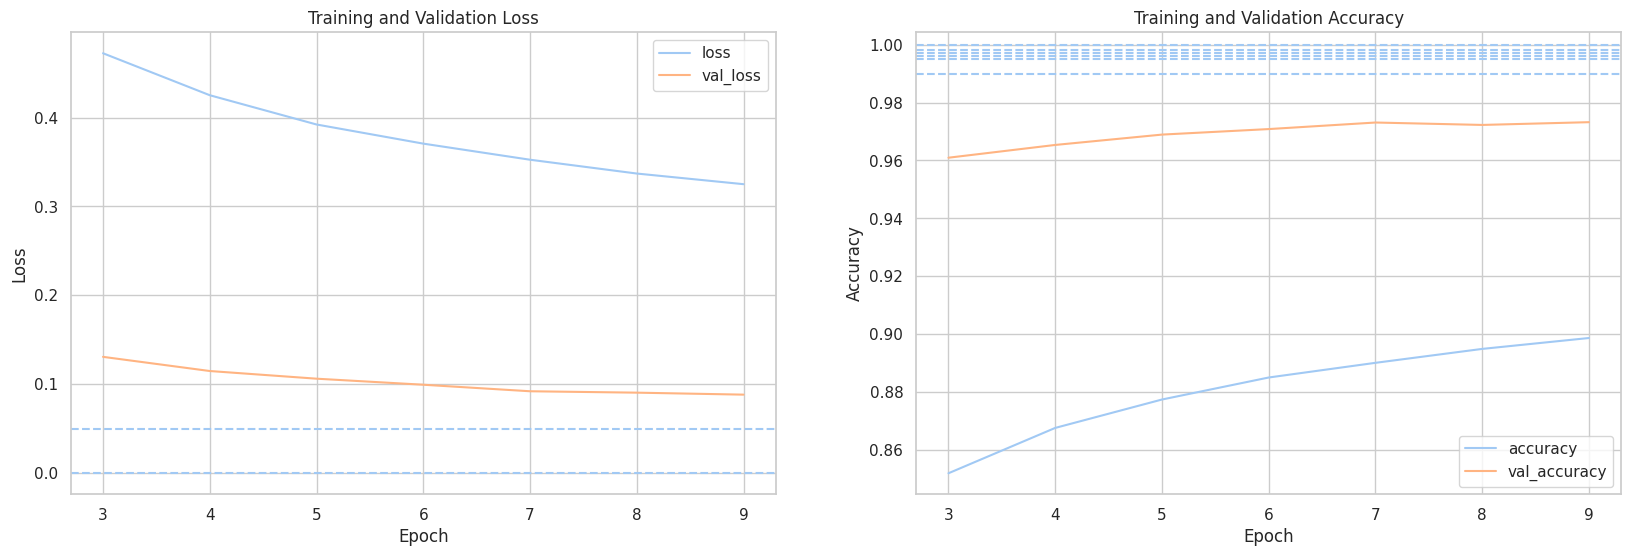

In [28]:
hist = []
for i in range(N_ITERATION):
    hist.append(pd.DataFrame(hist_df[hist_df['iteration']==(i+1)]['history'][i].history))
    if i==0:
        hist_full = hist[0]
    else:
        hist_full = pd.concat([hist_full, hist[i]])

# Dropping the 1st EPOCHS of each iteration because their losses are high and their accuracies are low
hist_full.drop([0,1,2], inplace=True)  # 3 EPOCHS dropped / iteration

# Displaying CV metrics
fig,axes=plt.subplots(1,2,figsize=(20,6))
sns.lineplot(data=hist_full[['loss','val_loss']], dashes=False, ax=axes[0])
axes[0].axhline(0.05, ls='--')
axes[0].axhline(0, ls='--')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
sns.lineplot(data=hist_full[['accuracy', 'val_accuracy']], dashes=False, ax=axes[1])
axes[1].axhline(0.99, ls='--')
axes[1].axhline(0.995, ls='--')
axes[1].axhline(0.996, ls='--')
axes[1].axhline(0.997, ls='--')
axes[1].axhline(0.998, ls='--')
axes[1].axhline(1, ls='--')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
plt.show()

#### Model Confusion Matrix

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


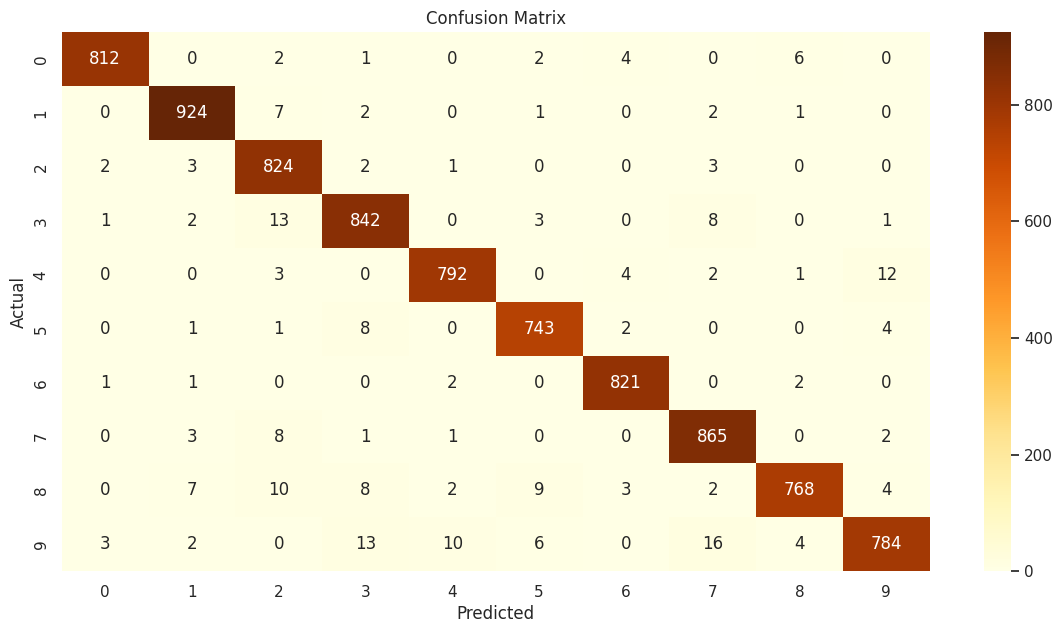

In [29]:
# Load the saved model
try:
    model = keras.models.load_model('MNIST/trained_models/Model-3L100N.keras')
except Exception as e:
    print(f"Error loading model: {e}")

# Reshape X_train
X_train = df_train.reshape(-1, 784)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=422)

# Retrieve the validation set from the first fold
for _, val_index in skf.split(X_train, y_train):
    X_val = X_train[val_index]
    y_val = y_train[val_index]
    break

# Reshape validation set for Keras
X_val = X_val.reshape(-1, 28, 28, 1)

# Make predictions
scores = model.predict(X_val)
y_pred = np.argmax(scores, axis=1)

# Display the confusion matrix
plt.figure(figsize=(14, 7))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Submission

In [30]:
X_test = df_test.copy()
X_test = X_test.reshape(28000,28,28,1)

model = keras.models.load_model('MNIST/trained_models/Model-3L100N.keras')
predictions = model.predict(X_test)

output = pd.DataFrame({'ImageId': list(range(1, 28001)), 'Label': np.argmax(predictions, axis=1)})
output.to_csv('MNIST/submission/Model-3L100N.csv', index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


#### Model 4 (3 layers, 200 node) Training with Cross-Validation

In [31]:
start_time = datetime.now()
# Creating hist_df to store history objects for each training / split
hist_df = pd.DataFrame(columns=['iteration', 'history'])
iteration = 1
index = 0

hidden_layers = 3
hidden_nodes = 200
dropout = 0.2

saved_model = False
X_train = df_train.reshape(42000, 784)

skf = StratifiedKFold(n_splits = N_SPLITS, shuffle = True, random_state = 422)
for train_index, val_index in skf.split(X_train, y_train):

    # Getting the training set and validation set before data augmentation
    X_train_, X_val_ = X_train[train_index], X_train[val_index]
    X_train_ = X_train_.reshape(33600,28,28,1) # Reshaping X_train to Keras input format
    X_val_ = X_val_.reshape(8400,28,28,1) # Reshaping X_val to Keras input format
    y_train_, y_val_ = y_train[train_index], y_train[val_index]

    # Generating augmented samples
    X_train_, y_train_ = data_augmentation(X_train_, y_train_)

    # Building the model
    model = build_model(hidden_layers, hidden_nodes, dropout)

    # EDIT THE NEXT ROW FOR EACH MODEL
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("MNIST/checkpoint/Model-3L200N.keras", save_best_only=True)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

    # Training and evaluating each model for this split
    history = model.fit(x = X_train_, y = y_train_, validation_data=(X_val_, y_val_),
                        epochs=N_EPOCHS, batch_size=64, callbacks=[checkpoint_cb, early_stopping_cb])

    # Saving the trained model as a saved model file -- only one model is saved
    if(saved_model == False):
        model.save('MNIST/trained_models/Model-3L200N.keras')
        saved_model = True

    # Storing the history objects into a dataframe
    hist_df.loc[index, 'iteration'] = iteration
    hist_df.loc[index, 'history'] = history

    if(iteration == N_ITERATION):
        break

    index = index + 1
    iteration = iteration + 1

end_time = datetime.now()
print('\nTime taken to Train Model with 3 Layers and 200 nodes: {}'.format(end_time - start_time))

Epoch 1/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.4707 - loss: 1.5589 - val_accuracy: 0.9324 - val_loss: 0.2513
Epoch 2/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8082 - loss: 0.6075 - val_accuracy: 0.9570 - val_loss: 0.1560
Epoch 3/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8617 - loss: 0.4443 - val_accuracy: 0.9637 - val_loss: 0.1218
Epoch 4/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8861 - loss: 0.3694 - val_accuracy: 0.9677 - val_loss: 0.1091
Epoch 5/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8977 - loss: 0.3254 - val_accuracy: 0.9713 - val_loss: 0.0963
Epoch 6/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9080 - loss: 0.2952 - val_accuracy: 0.9727 - val_loss: 0.0875
Epoch 7/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9142 - loss: 0.2722 - val_accuracy: 0.9757 - val_loss: 0.0833
Epoch 8/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9205 - loss: 0

#### Model Performance Evaluation

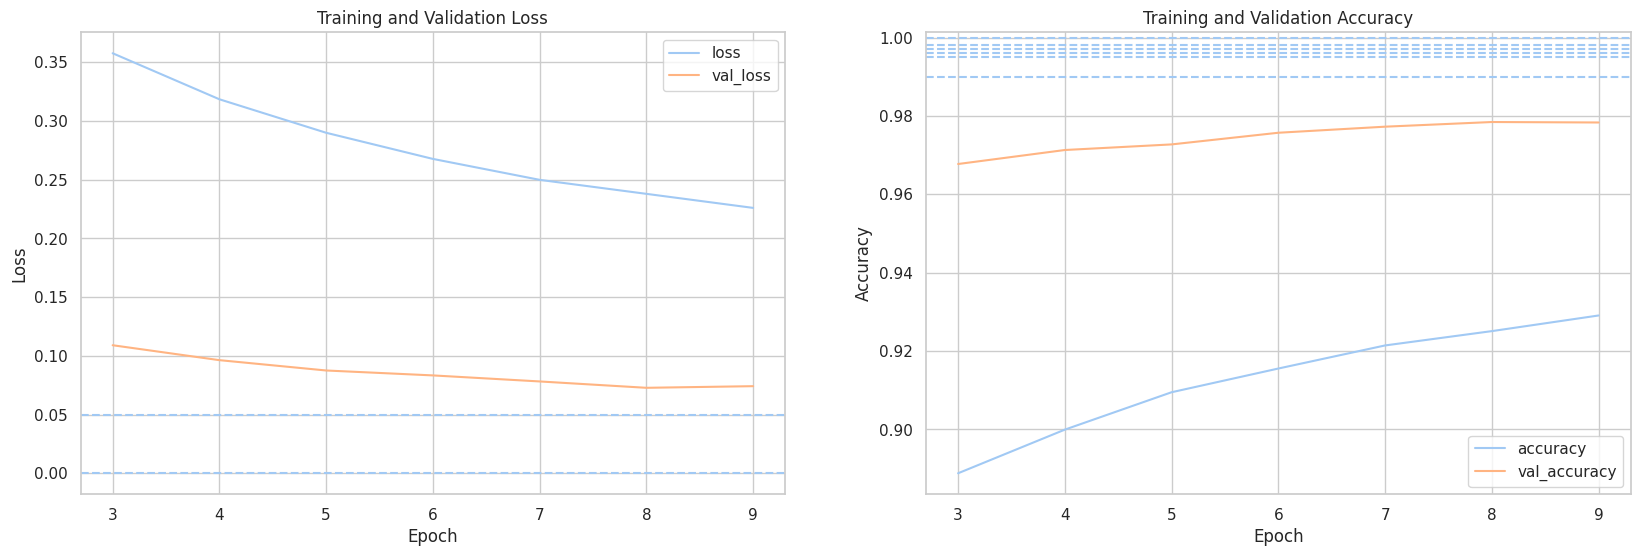

In [32]:
hist = []
for i in range(N_ITERATION):
    hist.append(pd.DataFrame(hist_df[hist_df['iteration']==(i+1)]['history'][i].history))
    if i==0:
        hist_full = hist[0]
    else:
        hist_full = pd.concat([hist_full, hist[i]])

# Dropping the 1st EPOCHS of each iteration because their losses are high and their accuracies are low
hist_full.drop([0,1,2], inplace=True)  # 3 EPOCHS dropped / iteration

# Displaying CV metrics
fig,axes=plt.subplots(1,2,figsize=(20,6))
sns.lineplot(data=hist_full[['loss','val_loss']], dashes=False, ax=axes[0])
axes[0].axhline(0.05, ls='--')
axes[0].axhline(0, ls='--')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
sns.lineplot(data=hist_full[['accuracy', 'val_accuracy']], dashes=False, ax=axes[1])
axes[1].axhline(0.99, ls='--')
axes[1].axhline(0.995, ls='--')
axes[1].axhline(0.996, ls='--')
axes[1].axhline(0.997, ls='--')
axes[1].axhline(0.998, ls='--')
axes[1].axhline(1, ls='--')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
plt.show()

#### Model Confusion Matrix

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


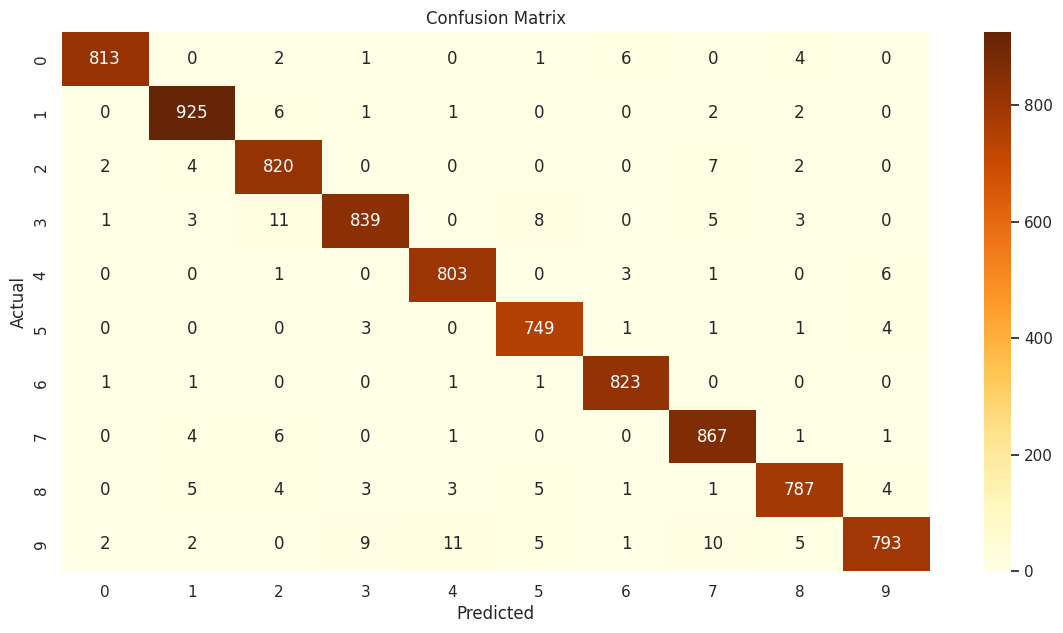

In [33]:
# Load the saved model
try:
    model = keras.models.load_model('MNIST/trained_models/Model-3L200N.keras')
except Exception as e:
    print(f"Error loading model: {e}")

# Reshape X_train
X_train = df_train.reshape(-1, 784)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=422)

# Retrieve the validation set from the first fold
for _, val_index in skf.split(X_train, y_train):
    X_val = X_train[val_index]
    y_val = y_train[val_index]
    break

# Reshape validation set for Keras
X_val = X_val.reshape(-1, 28, 28, 1)

# Make predictions
scores = model.predict(X_val)
y_pred = np.argmax(scores, axis=1)

# Display the confusion matrix
plt.figure(figsize=(14, 7))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Submission

In [34]:
X_test = df_test.copy()
X_test = X_test.reshape(28000,28,28,1)

model = keras.models.load_model('MNIST/trained_models/Model-3L200N.keras')
predictions = model.predict(X_test)

output = pd.DataFrame({'ImageId': list(range(1, 28001)), 'Label': np.argmax(predictions, axis=1)})
output.to_csv('MNIST/submission/Model-3L200N.csv', index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


#### Model 5 (5 layers, 100 node) Training with Cross-Validation

In [35]:
start_time = datetime.now()
# Creating hist_df to store history objects for each training / split
hist_df = pd.DataFrame(columns=['iteration', 'history'])
iteration = 1
index = 0

hidden_layers = 5
hidden_nodes = 100
dropout = 0.2

saved_model = False
X_train = df_train.reshape(42000, 784)

skf = StratifiedKFold(n_splits = N_SPLITS, shuffle = True, random_state = 422)
for train_index, val_index in skf.split(X_train, y_train):

    # Getting the training set and validation set before data augmentation
    X_train_, X_val_ = X_train[train_index], X_train[val_index]
    X_train_ = X_train_.reshape(33600,28,28,1) # Reshaping X_train to Keras input format
    X_val_ = X_val_.reshape(8400,28,28,1) # Reshaping X_val to Keras input format
    y_train_, y_val_ = y_train[train_index], y_train[val_index]

    # Generating augmented samples
    X_train_, y_train_ = data_augmentation(X_train_, y_train_)

    # Building the model
    model = build_model(hidden_layers, hidden_nodes, dropout)

    # EDIT THE NEXT ROW FOR EACH MODEL
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("MNIST/checkpoint/Model-5L100N.keras", save_best_only=True)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

    # Training and evaluating each model for this split
    history = model.fit(x = X_train_, y = y_train_, validation_data=(X_val_, y_val_),
                        epochs=N_EPOCHS, batch_size=64, callbacks=[checkpoint_cb, early_stopping_cb])

    # Saving the trained model as a saved model file -- only one model is saved
    if(saved_model == False):
        model.save('MNIST/trained_models/Model-5L100N.keras')
        saved_model = True

    # Storing the history objects into a dataframe
    hist_df.loc[index, 'iteration'] = iteration
    hist_df.loc[index, 'history'] = history

    if(iteration == N_ITERATION):
        break

    index = index + 1
    iteration = iteration + 1

end_time = datetime.now()
print('\nTime taken to Train Model with 5 Layers and 100 nodes: {}'.format(end_time - start_time))

Epoch 1/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.3001 - loss: 1.9434 - val_accuracy: 0.8989 - val_loss: 0.3805
Epoch 2/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.7230 - loss: 0.8545 - val_accuracy: 0.9455 - val_loss: 0.1943
Epoch 3/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8120 - loss: 0.6083 - val_accuracy: 0.9580 - val_loss: 0.1438
Epoch 4/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8454 - loss: 0.5101 - val_accuracy: 0.9650 - val_loss: 0.1253
Epoch 5/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8630 - loss: 0.4539 - val_accuracy: 0.9656 - val_loss: 0.1220
Epoch 6/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8742 - loss: 0.4183 - val_accuracy: 0.9689 - val_loss: 0.1137
Epoch 7/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8826 - loss: 0.3941 - val_accuracy: 0.9717 - val_loss: 0.1018
Epoch 8/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8878 - loss: 0

#### Model Performance Evaluation

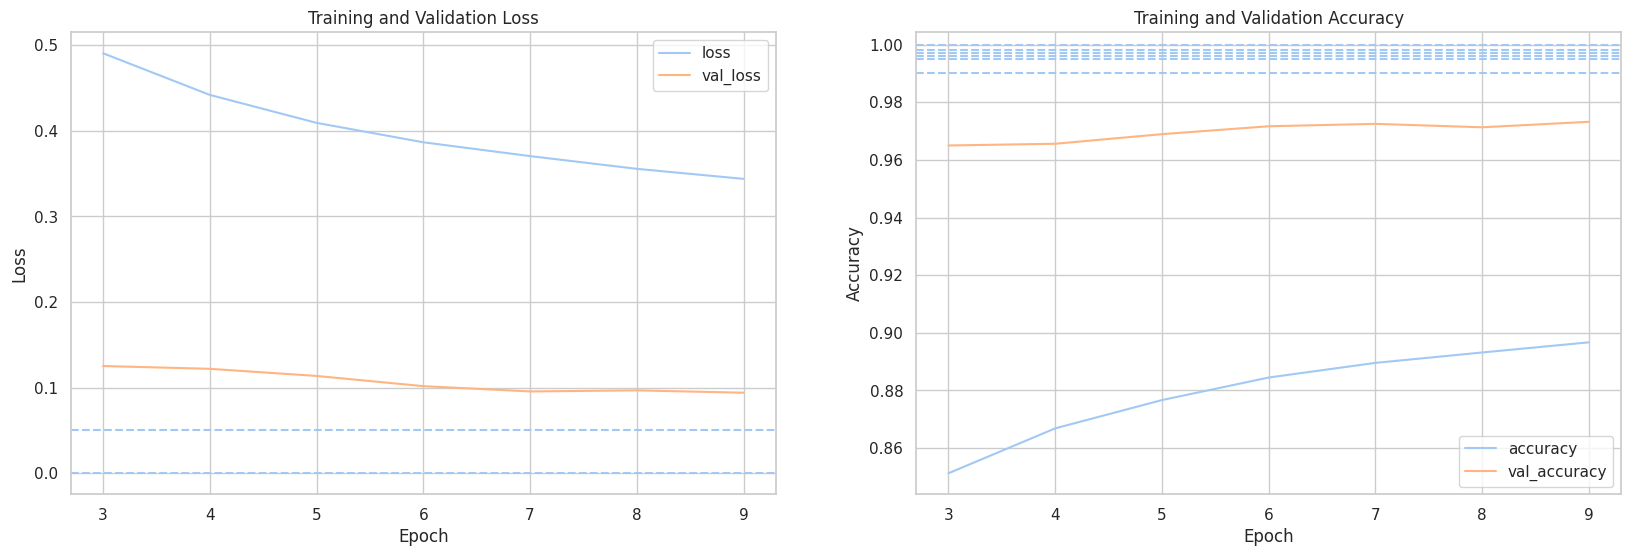

In [36]:
hist = []
for i in range(N_ITERATION):
    hist.append(pd.DataFrame(hist_df[hist_df['iteration']==(i+1)]['history'][i].history))
    if i==0:
        hist_full = hist[0]
    else:
        hist_full = pd.concat([hist_full, hist[i]])

# Dropping the 1st EPOCHS of each iteration because their losses are high and their accuracies are low
hist_full.drop([0,1,2], inplace=True)  # 3 EPOCHS dropped / iteration

# Displaying CV metrics
fig,axes=plt.subplots(1,2,figsize=(20,6))
sns.lineplot(data=hist_full[['loss','val_loss']], dashes=False, ax=axes[0])
axes[0].axhline(0.05, ls='--')
axes[0].axhline(0, ls='--')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
sns.lineplot(data=hist_full[['accuracy', 'val_accuracy']], dashes=False, ax=axes[1])
axes[1].axhline(0.99, ls='--')
axes[1].axhline(0.995, ls='--')
axes[1].axhline(0.996, ls='--')
axes[1].axhline(0.997, ls='--')
axes[1].axhline(0.998, ls='--')
axes[1].axhline(1, ls='--')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
plt.show()

#### Model Confusion Matrix

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


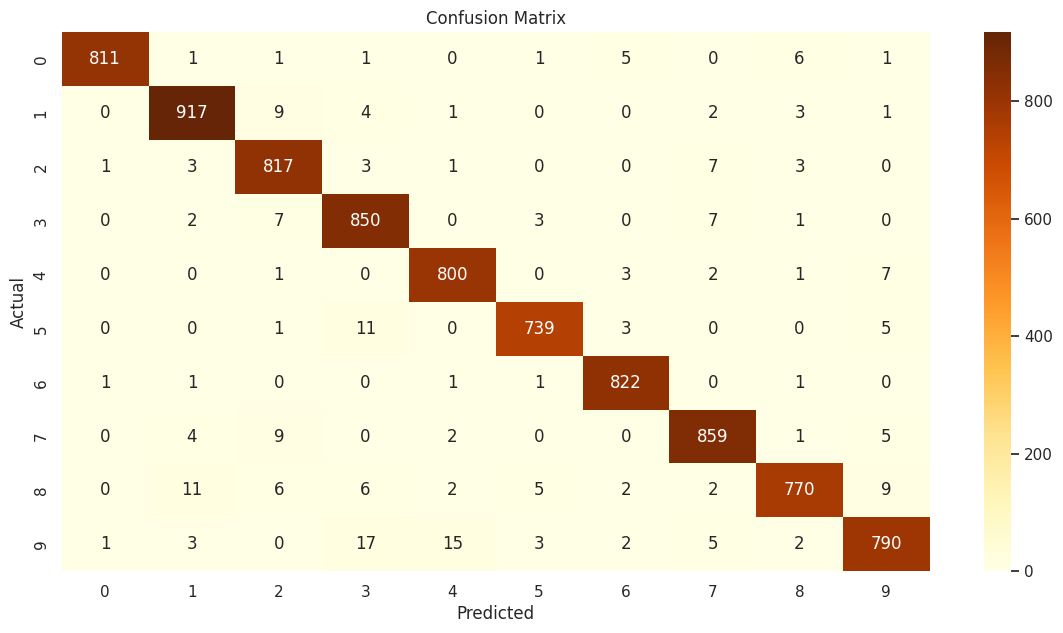

In [37]:
# Load the saved model
try:
    model = keras.models.load_model('MNIST/trained_models/Model-5L100N.keras')
except Exception as e:
    print(f"Error loading model: {e}")

# Reshape X_train
X_train = df_train.reshape(-1, 784)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=422)

# Retrieve the validation set from the first fold
for _, val_index in skf.split(X_train, y_train):
    X_val = X_train[val_index]
    y_val = y_train[val_index]
    break

# Reshape validation set for Keras
X_val = X_val.reshape(-1, 28, 28, 1)

# Make predictions
scores = model.predict(X_val)
y_pred = np.argmax(scores, axis=1)

# Display the confusion matrix
plt.figure(figsize=(14, 7))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Submission

In [38]:
X_test = df_test.copy()
X_test = X_test.reshape(28000,28,28,1)

model = keras.models.load_model('MNIST/trained_models/Model-5L100N.keras')
predictions = model.predict(X_test)

output = pd.DataFrame({'ImageId': list(range(1, 28001)), 'Label': np.argmax(predictions, axis=1)})
output.to_csv('MNIST/submission/Model-5L100N.csv', index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


#### Model 6 (5 layers, 200 node) Training with Cross-Validation

In [43]:
start_time = datetime.now()
# Creating hist_df to store history objects for each training / split
hist_df = pd.DataFrame(columns=['iteration', 'history'])
iteration = 1
index = 0

hidden_layers = 5
hidden_nodes = 200
dropout = 0.2

saved_model = False
X_train = df_train.reshape(42000, 784)

skf = StratifiedKFold(n_splits = N_SPLITS, shuffle = True, random_state = 422)
for train_index, val_index in skf.split(X_train, y_train):

    # Getting the training set and validation set before data augmentation
    X_train_, X_val_ = X_train[train_index], X_train[val_index]
    X_train_ = X_train_.reshape(33600,28,28,1) # Reshaping X_train to Keras input format
    X_val_ = X_val_.reshape(8400,28,28,1) # Reshaping X_val to Keras input format
    y_train_, y_val_ = y_train[train_index], y_train[val_index]

    # Generating augmented samples
    X_train_, y_train_ = data_augmentation(X_train_, y_train_)

    # Building the model
    model = build_model(hidden_layers, hidden_nodes, dropout)

    # EDIT THE NEXT ROW FOR EACH MODEL
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("MNIST/checkpoint/Model-5L200N.keras", save_best_only=True)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

    # Training and evaluating each model for this split
    history = model.fit(x = X_train_, y = y_train_, validation_data=(X_val_, y_val_),
                        epochs=N_EPOCHS, batch_size=64, callbacks=[checkpoint_cb, early_stopping_cb])

    # Saving the trained model as a saved model file -- only one model is saved
    if(saved_model == False):
        model.save('MNIST/trained_models/Model-5L200N.keras')
        saved_model = True

    # Storing the history objects into a dataframe
    hist_df.loc[index, 'iteration'] = iteration
    hist_df.loc[index, 'history'] = history

    if(iteration == N_ITERATION):
        break

    index = index + 1
    iteration = iteration + 1

end_time = datetime.now()
print('\nTime taken to Train Model with 5 Layers and 200 nodes: {}'.format(end_time - start_time))

Epoch 1/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.3637 - loss: 1.7848 - val_accuracy: 0.9287 - val_loss: 0.2437
Epoch 2/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8013 - loss: 0.6271 - val_accuracy: 0.9554 - val_loss: 0.1438
Epoch 3/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8629 - loss: 0.4401 - val_accuracy: 0.9665 - val_loss: 0.1115
Epoch 4/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8896 - loss: 0.3598 - val_accuracy: 0.9699 - val_loss: 0.1006
Epoch 5/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9032 - loss: 0.3169 - val_accuracy: 0.9717 - val_loss: 0.0903
Epoch 6/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9109 - loss: 0.2881 - val_accuracy: 0.9733 - val_loss: 0.0832
Epoch 7/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9184 - loss: 0.2674 - val_accuracy: 0.9756 - val_loss: 0.0815
Epoch 8/10
5250/5250 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9245 - loss: 0

#### Model Performance Evaluation

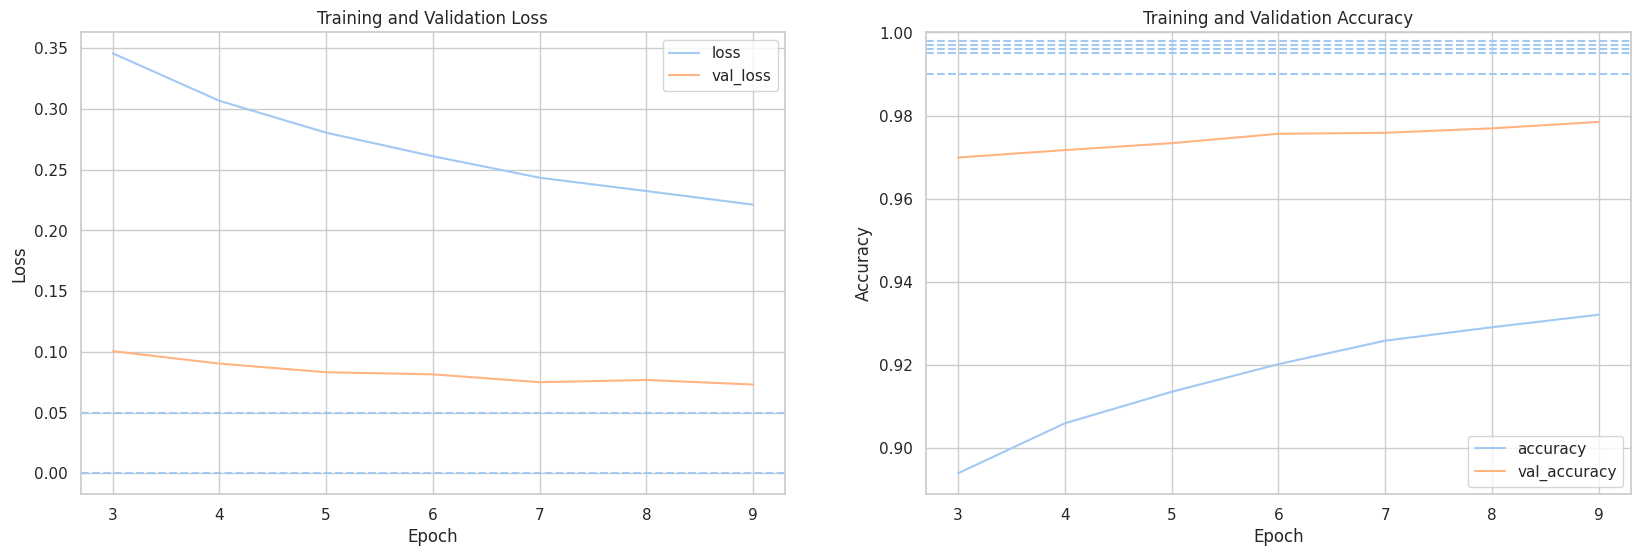

In [44]:
hist = []
for i in range(N_ITERATION):
    hist.append(pd.DataFrame(hist_df[hist_df['iteration']==(i+1)]['history'][i].history))
    if i==0:
        hist_full = hist[0]
    else:
        hist_full = pd.concat([hist_full, hist[i]])

# Dropping the 1st EPOCHS of each iteration because their losses are high and their accuracies are low
hist_full.drop([0,1,2], inplace=True)  # 3 EPOCHS dropped / iteration

# Displaying CV metrics
fig,axes=plt.subplots(1,2,figsize=(20,6))
sns.lineplot(data=hist_full[['loss','val_loss']], dashes=False, ax=axes[0])
axes[0].axhline(0.05, ls='--')
axes[0].axhline(0, ls='--')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
sns.lineplot(data=hist_full[['accuracy', 'val_accuracy']], dashes=False, ax=axes[1])
axes[1].axhline(0.99, ls='--')
axes[1].axhline(0.995, ls='--')
axes[1].axhline(0.996, ls='--')
axes[1].axhline(0.997, ls='--')
axes[1].axhline(0.998, ls='--')
axes[1].axhline(1, ls='--')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
plt.show()

#### Model Confusion Matrix

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


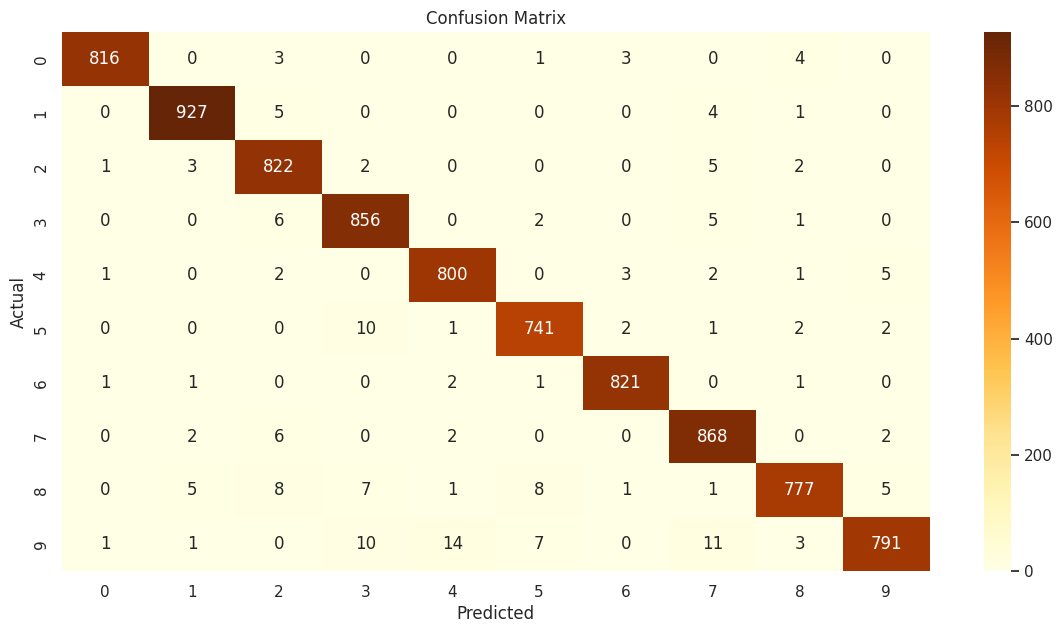

In [45]:
# Load the saved model
try:
    model = keras.models.load_model('MNIST/trained_models/Model-5L200N.keras')
except Exception as e:
    print(f"Error loading model: {e}")

# Reshape X_train
X_train = df_train.reshape(-1, 784)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=422)

# Retrieve the validation set from the first fold
for _, val_index in skf.split(X_train, y_train):
    X_val = X_train[val_index]
    y_val = y_train[val_index]
    break

# Reshape validation set for Keras
X_val = X_val.reshape(-1, 28, 28, 1)

# Make predictions
scores = model.predict(X_val)
y_pred = np.argmax(scores, axis=1)

# Display the confusion matrix
plt.figure(figsize=(14, 7))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Submission

In [46]:
X_test = df_test.copy()
X_test = X_test.reshape(28000,28,28,1)

model = keras.models.load_model('MNIST/trained_models/Model-5L200N.keras')
predictions = model.predict(X_test)

output = pd.DataFrame({'ImageId': list(range(1, 28001)), 'Label': np.argmax(predictions, axis=1)})
output.to_csv('MNIST/submission/Model-5L200N.csv', index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


**Management/Research Question**

In layman’s terms, what is the management/research question of interest, and why would anyone care?  

**Research Question: How can we design the most effective neural network for accurately recognizing handwritten digits?**

**Why It Matters:**
In today's digital world, the ability to automatically and accurately recognize handwritten digits has a wide range of applications. From automating the sorting of postal mail to enabling quick and secure check deposits through mobile apps, the potential benefits are significant. Effective digit recognition can streamline processes, reduce errors, and save time.

Understanding which neural network configurations (e.g., number of layers and nodes) yield the best performance is crucial for improving the accuracy and efficiency of these systems. By systematically experimenting with different network structures, we can identify the optimal design that balances accuracy and computational efficiency. This knowledge can then be applied to develop better AI systems for various practical applications, ultimately enhancing productivity and user experience.